# SUBMISSION TAHAP 2 DICODING
 
"Air Pollution Forecasting"
 
Timeseries Multivariate

#DATA DIRI

Nama = Sultan Syach
 
Gmail = sultanbst123@gmail.com
 
No.Hp = 085810260040
 
kota Domisili = Jakarta Timur
 
Tempat/Tanggal Lahir = PadangPanjang,19-07-2002
 
Pendidikan Terakhir = SMK

#LIBRARY

In [ ]:
pip install mplcyberpunk

In [ ]:
#basic library
import numpy as np
import pandas as pd
from datetime import datetime
 
#deep learning library
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Bidirectional, GRU #RNN LAYERS
from tensorflow.keras.layers import Dense, Dropout, Flatten #ANN LAYERS
from tensorflow.keras.layers import Conv1D, MaxPooling1D #CNN LAYERS
from tensorflow.keras.callbacks import EarlyStopping #CALLBACKS
 
#visualization library
import mplcyberpunk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
#preprocesing library
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
 
import warnings
warnings.filterwarnings("ignore")
plt.style.use("cyberpunk")

#FILE

In [ ]:
!pip install -U -q PyDrive 
 
  
 
from pydrive.auth import GoogleAuth 
 
from pydrive.drive import GoogleDrive 
 
from google.colab import auth 
 
from oauth2client.client import GoogleCredentials 
 
  
 
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
 
gauth = GoogleAuth() 
 
gauth.credentials = GoogleCredentials.get_application_default() 
 
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1aVQKfdj4cVsoG8FHLGtX_RZ5HjZe3XnV/view?usp=drivesdk'
 
# to get the id part of the file 
 
id = link.split("/")[-2] 
  
 
downloaded = drive.CreateFile({'id':id})  
 
downloaded.GetContentFile('Pollution.csv')   
 
 
df = pd.read_csv('Pollution.csv') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


# PREPROCESING

"Saya akan mengabungkan column 
[year month day hour] menjadi datetime dan menjadikan nya index, menganti nama column yang susah dipahami"

In [ ]:
df['time'] = df.apply(lambda x : datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1) 
df = df.set_index("time")

In [ ]:
df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  41757 non-null  float64
 1   dew        43824 non-null  int64  
 2   temp       43824 non-null  float64
 3   press      43824 non-null  float64
 4   wnd_dir    43824 non-null  object 
 5   wnd_spd    43824 non-null  float64
 6   snow       43824 non-null  int64  
 7   rain       43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


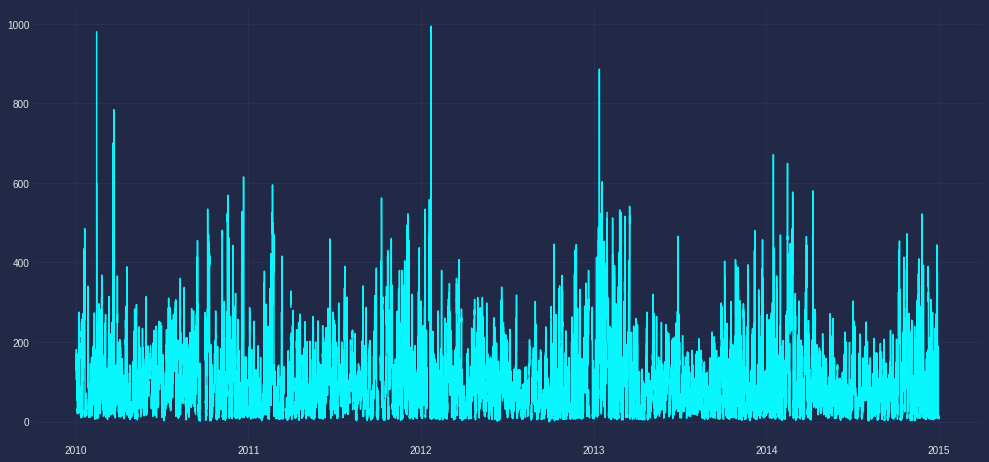

In [ ]:
#terdapat banyak trend dan musiman 
plt.figure(figsize=(17,8))
plt.plot(df["pollution"])

In [ ]:
# mengisi nilai nan menjadi 0
df['pollution'].fillna(0, inplace=True)
df.drop_duplicates(inplace = True) 
 
# drop first 24 hour
df = df [24:]
 
df.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [ ]:
print(df.isnull().sum(),"\n") 
print(df.duplicated().sum())

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64 

0


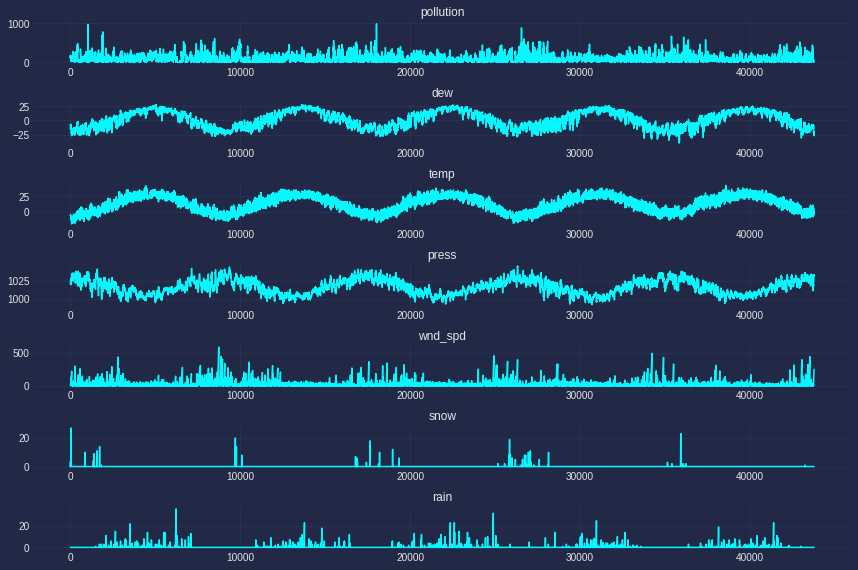

In [ ]:
 #convert to values
values = df.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
plt.figure(figsize=(12,8))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group])
    i += 1
 
plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0) 
plt.show()

#ENCODER & NORMALIZE

In [ ]:
#encode
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
 
# normalize features
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#TIME SERIES TO SUPERVISED LEARNING

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
 
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
 
    # drop nan
    if dropnan:
       agg.dropna(inplace=True)
 
    return agg

In [ ]:
#convert
toframed = series_to_supervised(scaled, 1, 1)
 
# drop columns we don't want
toframed.drop(toframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
toframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [ ]:
toframed.shape

(43785, 9)

#SPLIT

In [ ]:
# split into train and test sets
values = toframed.values
n_train_hours = 365 * 24
train = values[n_train_hours:, :]
test = values[:n_train_hours, :]
print(train.shape) 
print(test.shape)

(35025, 9)
(8760, 9)


In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35025, 1, 8) (35025,) (8760, 1, 8) (8760,)


#MODELING

In [ ]:
earlystop = EarlyStopping(monitor='val_loss',patience=10)

In [ ]:
models = Sequential()
models.add(LSTM(units = 100, return_sequences = True,input_shape = (train_X.shape[1],train_X.shape[2])))
models.add(Dropout(0.4)) 
 
models.add(LSTM(units = 75,return_sequences = True))
models.add(Dropout(0.3))
 
models.add(LSTM(units = 75,return_sequences = True))
models.add(Dropout(0.3)) 
 
models.add(LSTM(units = 50)) 
models.add(Dropout(0.2))
 
models.add(Dense(1))
 
models.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1, 100)            43600     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 100)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1, 75)             52800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 75)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 75)             45300     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 75)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)               

In [ ]:
#compile model
ADAM = tf.keras.optimizers.Adam(learning_rate=0.003)
RMS = tf.keras.optimizers.RMSprop(learning_rate=0.001) 
 
models.compile(loss="mean_squared_error", optimizer=ADAM,metrics = ["mean_absolute_error"])

In [ ]:
# fit network
epoch = 50
bc = 75
 
history = models.fit(train_X, train_y, 
                    epochs=epoch, batch_size=bc,
                    validation_data=(test_X, test_y), 
                    verbose=1, callbacks = earlystop,
                    shuffle=False)

Epoch 1/50
467/467 [==============================] - 9s 10ms/step - loss: 0.0042 - mean_absolute_error: 0.0423 - val_loss: 0.0019 - val_mean_absolute_error: 0.0301
Epoch 2/50
467/467 [==============================] - 3s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0228 - val_loss: 0.0014 - val_mean_absolute_error: 0.0239
Epoch 3/50
467/467 [==============================] - 3s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0218 - val_loss: 0.0013 - val_mean_absolute_error: 0.0224
Epoch 4/50
467/467 [==============================] - 3s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0208 - val_loss: 0.0012 - val_mean_absolute_error: 0.0226
Epoch 5/50
467/467 [==============================] - 3s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0213 - val_loss: 0.0014 - val_mean_absolute_error: 0.0252
Epoch 6/50
467/467 [==============================] - 3s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0208 - val_loss: 0.0014 - val_mean_absolute_error: 0.0244
Epoch 7/50
467/

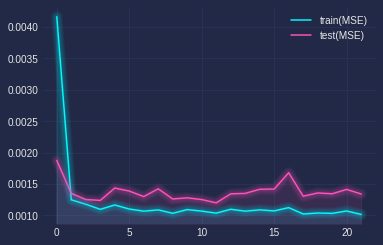

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train(MSE)') 
plt.plot(history.history['val_loss'], label='test(MSE)')
plt.legend()
mplcyberpunk.add_glow_effects() 
plt.show()

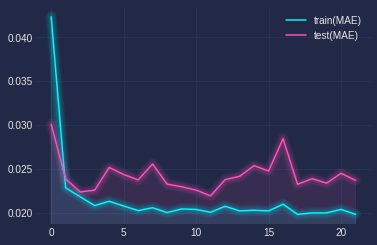

In [ ]:
# plot history
plt.plot(history.history['mean_absolute_error'], label='train(MAE)') 
plt.plot(history.history['val_mean_absolute_error'], label='test(MAE)')
plt.legend()
mplcyberpunk.add_glow_effects() 
plt.show()

In [ ]:
# make a prediction
yhat = models.predict(test_X)

In [ ]:
# invert scaling for forecast
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
r2 = r2_score(inv_y, inv_yhat)
print('r2: %.3f' % r2)

r2: 0.846


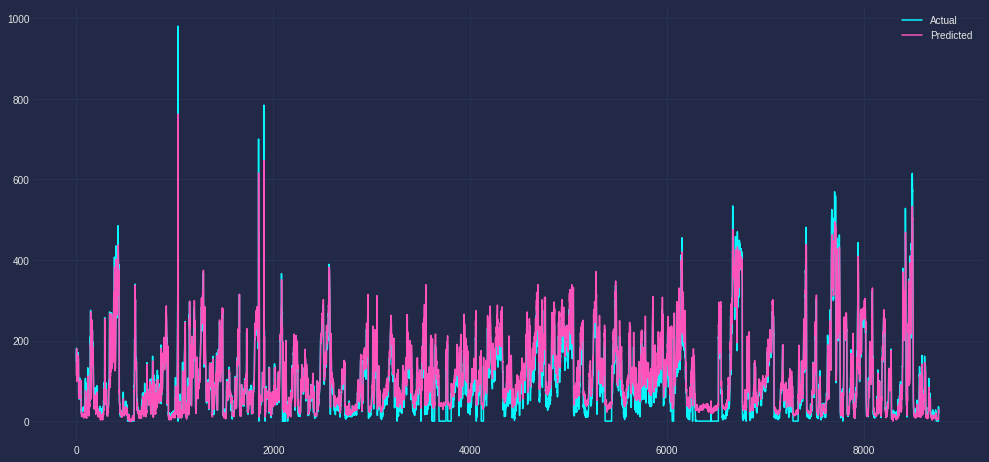

In [ ]:
#plot actual vs predicted
plt.figure(figsize=(17, 8)) 
plt.plot(inv_y, label='Actual') 
plt.plot(inv_yhat, label='Predicted')
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({"actual": inv_y,"Predicted": inv_yhat})

,actual,Predicted
0,148.0,114.539177
1,159.0,135.648438
2,181.0,152.501648
3,138.0,179.676224
4,109.0,132.259903
...,...,...
8755,0.0,6.284672
8756,0.0,5.215826
8757,36.0,6.873639
8758,31.0,28.490448


 
-Karena ini bukan mengunakan model tradisonal yang harus mengubah data menjadi stationery, jadi mengunakan RNN adalah cara modern untuk memainkan data time series karena NN data tidak harus stationery 
 
-Model nya ngepas dan bagus 
 
DONE, terima kasih